# Moving average crossing strategies

In [2]:
import numpy as np
import pandas as pd

import bt
import matplotlib.pyplot as plt
import talib
# import seaborn as sns

%matplotlib inline

# sns.set_style('darkgrid')

In [3]:
stocks = bt.get("AAPL, AMZN, META, GOOG, NFLX, INTC, BA", start="2011-01-01", end="2024-12-31")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
aapl = stocks["aapl"].to_frame(name="Close")
aapl.info()

intc = stocks["intc"].to_frame(name="Close")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3174 entries, 2012-05-18 to 2024-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3174 non-null   float64
dtypes: float64(1)
memory usage: 49.6 KB


## Analysis the trend

From a 13 year time frame, Apple has been on a rising trend, with low volatility, with two large consolidations occuring around 2022 and 2024. While Intel has been much more volatile, it is on a rising trend until 2020, with large drawdowns, tops forming between 2020 and 2022 and enters a downtrend with a big bounce at the beginning of 2024 but short lived. 

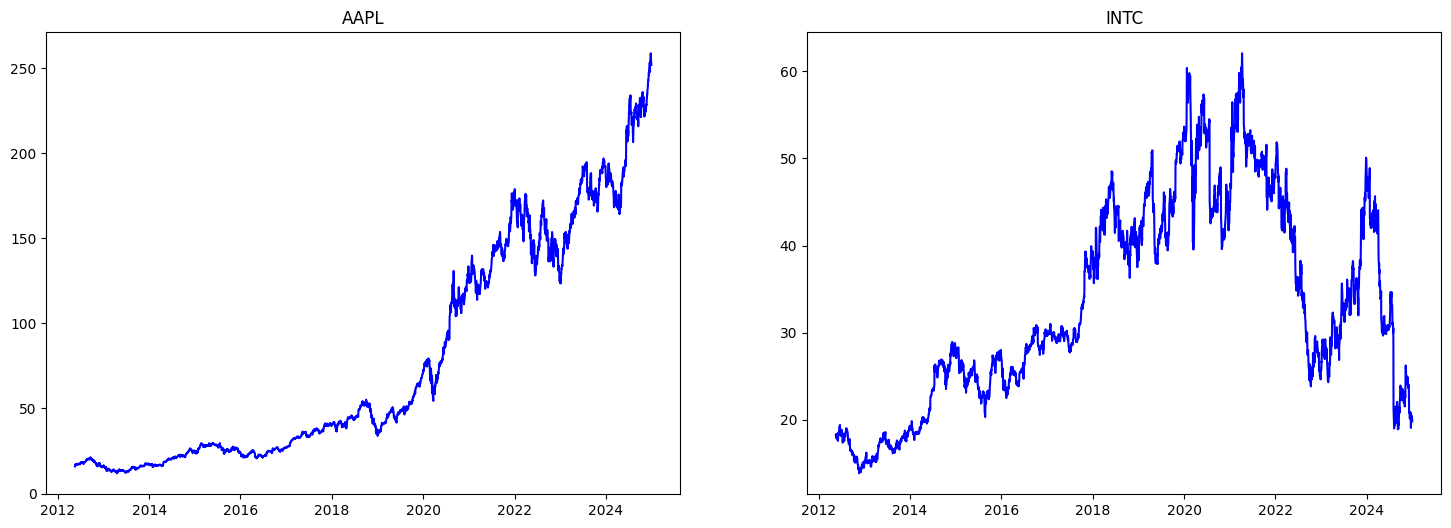

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(aapl.index, aapl["Close"], label="AAPL", color="blue")
ax1.set_title("AAPL")

ax2.plot(intc.index, intc["Close"], label="INTC", color="blue")
ax2.set_title("INTC")
plt.show()



## Explore the relationship between moving averages

In [8]:
aapl_sma20 = talib.SMA(aapl["Close"], timeperiod=20)
aapl_sma50 = talib.SMA(aapl["Close"], timeperiod=50)
aapl_sma100 = talib.SMA(aapl["Close"], timeperiod=100)
aapl_sma200 = talib.SMA(aapl["Close"], timeperiod=200)

aapl_df = pd.concat([aapl, aapl_sma20, aapl_sma50, aapl_sma100, aapl_sma200], axis=1)
aapl_df.columns = ["Close", "SMA20", "SMA50", "SMA100", "SMA200"]

aapl_df.tail()

,Close,SMA20,SMA50,SMA100,SMA200
Date,,,,,
2024-12-23,254.989655,244.757892,235.021529,228.969606,210.752679
2024-12-24,257.916443,246.023002,235.564016,229.357535,211.182570
2024-12-26,258.735504,247.219685,236.071997,229.859200,211.614168
2024-12-27,255.309296,248.251551,236.552763,230.346935,212.039086
2024-12-30,251.923019,248.994234,236.958420,230.774993,212.437766


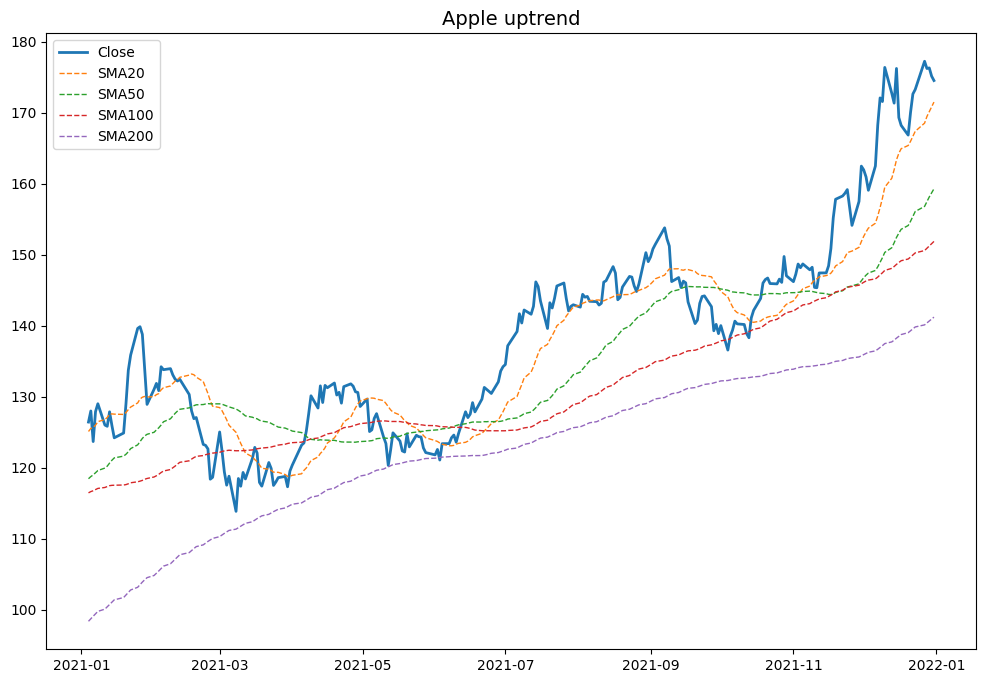

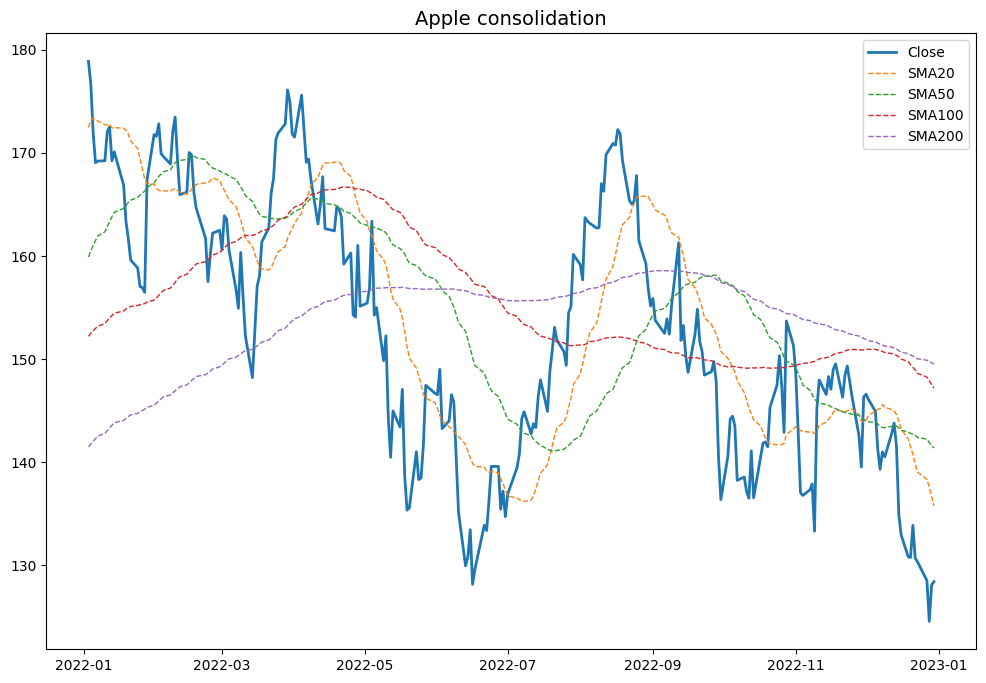

In [9]:
aapl2021 = aapl_df.loc["2021-01":"2021-12"]
aapl2022 = aapl_df.loc["2022-01":"2022-12"]


def plot_price_with_ma(data, title):
    plt.figure(figsize=(12, 8))
    plt.plot(data["Close"], label="Close", linewidth= 2, color="C0")
    plt.plot(data["SMA20"], label="SMA20", linewidth= 1, color="C1", linestyle="--")
    plt.plot(data["SMA50"], label="SMA50", linewidth= 1, color="C2", linestyle="--") 
    plt.plot(data["SMA100"], label="SMA100", linewidth= 1, color="C3", linestyle="--")
    plt.plot(data["SMA200"], label="SMA200", linewidth= 1, color="C4", linestyle="--")

    plt.title(title, fontsize=14)
    plt.legend()
    plt.show()


plot_price_with_ma(aapl2021, "Apple uptrend")
plot_price_with_ma(aapl2022, "Apple consolidation")

In [10]:
intc_sma20 = talib.SMA(intc["Close"], timeperiod=20)
intc_sma50 = talib.SMA(intc["Close"], timeperiod=50)
intc_sma100 = talib.SMA(intc["Close"], timeperiod=100)
intc_sma200 = talib.SMA(intc["Close"], timeperiod=200)

intc_df = pd.concat([intc, intc_sma20, intc_sma50, intc_sma100, intc_sma200], axis=1)
intc_df.columns = ["Close", "SMA20", "SMA50", "SMA100", "SMA200"]
intc_df.tail()


,Close,SMA20,SMA50,SMA100,SMA200
Date,,,,,
2024-12-23,20.200001,21.4130,22.7156,21.905828,27.893952
2024-12-24,20.400000,21.1895,22.6548,21.896382,27.773968
2024-12-26,20.440001,21.0090,22.6104,21.900950,27.652303
2024-12-27,20.299999,20.8415,22.5702,21.906900,27.539884
2024-12-30,19.820000,20.6300,22.5178,21.915200,27.427441


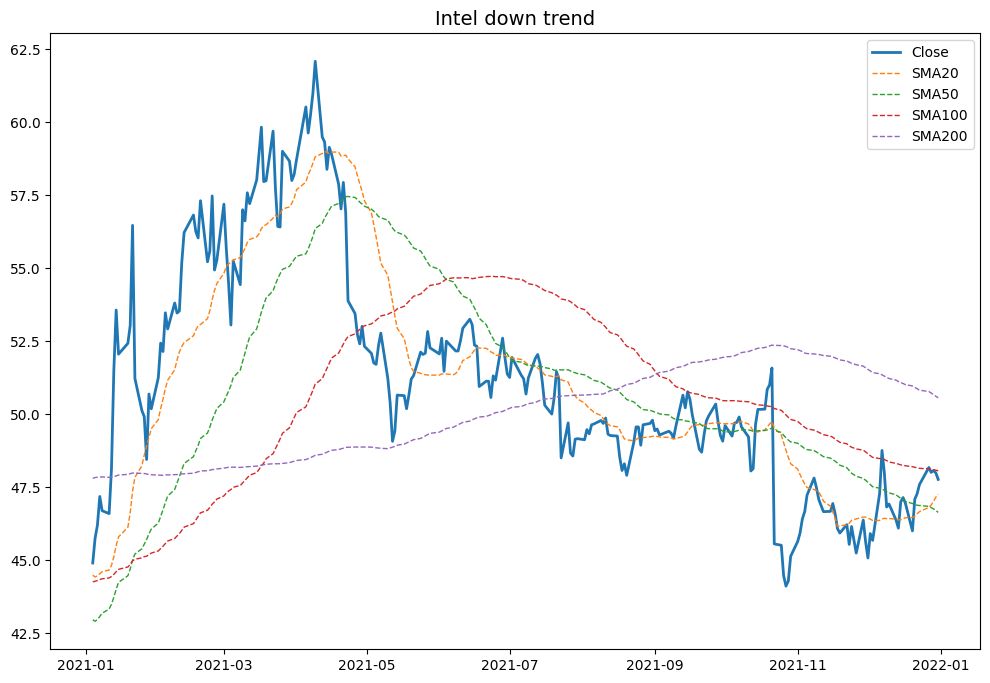

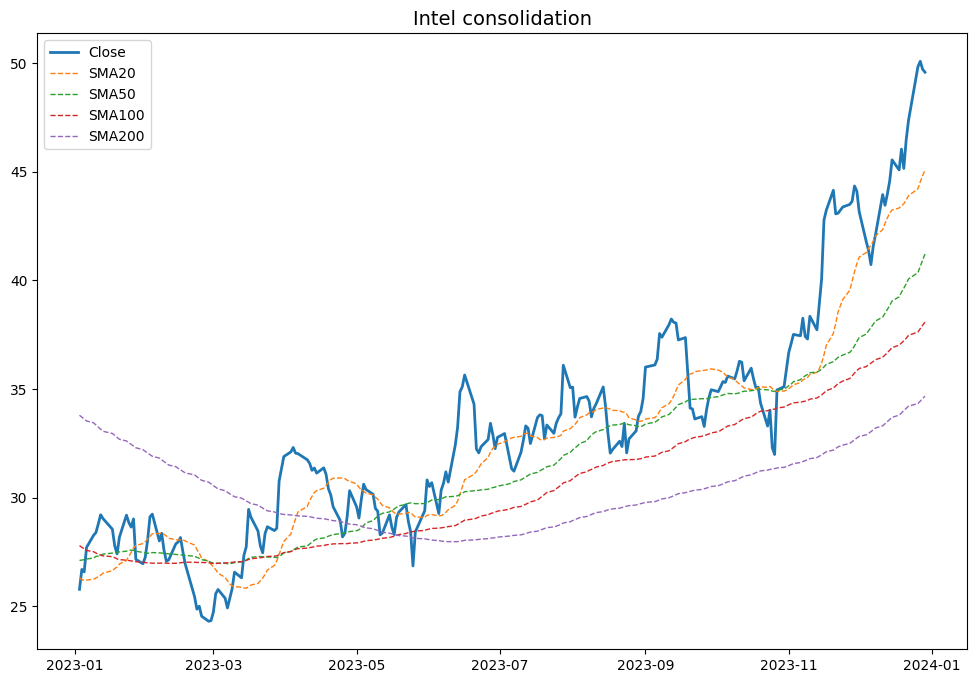

In [11]:
intc2021 = intc_df.loc["2021-01":"2021-12"]
intc2023 = intc_df.loc["2023-01":"2023-12"]

plot_price_with_ma(intc2021, "Intel down trend")
plot_price_with_ma(intc2023, "Intel consolidation")

## Strategy v1.0 20MA > 50MA

Trading rules: 
1. when 20MA rises above 50MA, buy and hold 25% 
2. when 20MA rises above 100MA, buy additional 25% and hold 50%
3. when 20MA rises above 200MA, buy additional 25% and hold 75%
   
4. when 20MA falls above 50MA, reduce position by 25% and hold 50%
5. when 20MA falls above 100MA, reduce position by 25% and hold 25%
6. when 20MA falls above 200MA, reduce position by 25% and hold 0%

In [36]:
aapl_df.shape[0]
signal = [""] * aapl_df.shape[0]
signal = pd.DataFrame(signal, index=aapl_df.index, columns=["Signal"])

signal.loc[aapl_df["SMA20"] > aapl_df["SMA50"], "Signal"] = "buy1"
signal.loc[aapl_df["SMA20"] > aapl_df["SMA100"], "Signal"] = "buy2"
signal.loc[aapl_df["SMA20"] > aapl_df["SMA200"], "Signal"] = "buy3"
signal.loc[aapl_df["SMA20"] < aapl_df["SMA50"], "Signal"] = "sell1"
signal.loc[aapl_df["SMA20"] < aapl_df["SMA100"], "Signal"] = "sell2"
signal.loc[aapl_df["SMA20"] < aapl_df["SMA200"], "Signal"] = "sell3"

signal

,Signal
Date,
2012-05-18,
2012-05-21,
2012-05-22,
2012-05-23,
2012-05-24,
...,...
2024-12-23,buy3
2024-12-24,buy3
2024-12-26,buy3


In [37]:
weight = signal["Signal"].map({
    "buy1": 0.5,
    "buy2": 0.75,
    "buy3": 1.0,
    "sell1": 0.75,
    "sell2": 0.5,
    "sell3": 0.0,
}).copy()
weight = weight.to_frame(name="Weight")
weight.fillna(0, inplace=True)
weight

,Weight
Date,
2012-05-18,0.0
2012-05-21,0.0
2012-05-22,0.0
2012-05-23,0.0
2012-05-24,0.0
...,...
2024-12-23,1.0
2024-12-24,1.0
2024-12-26,1.0


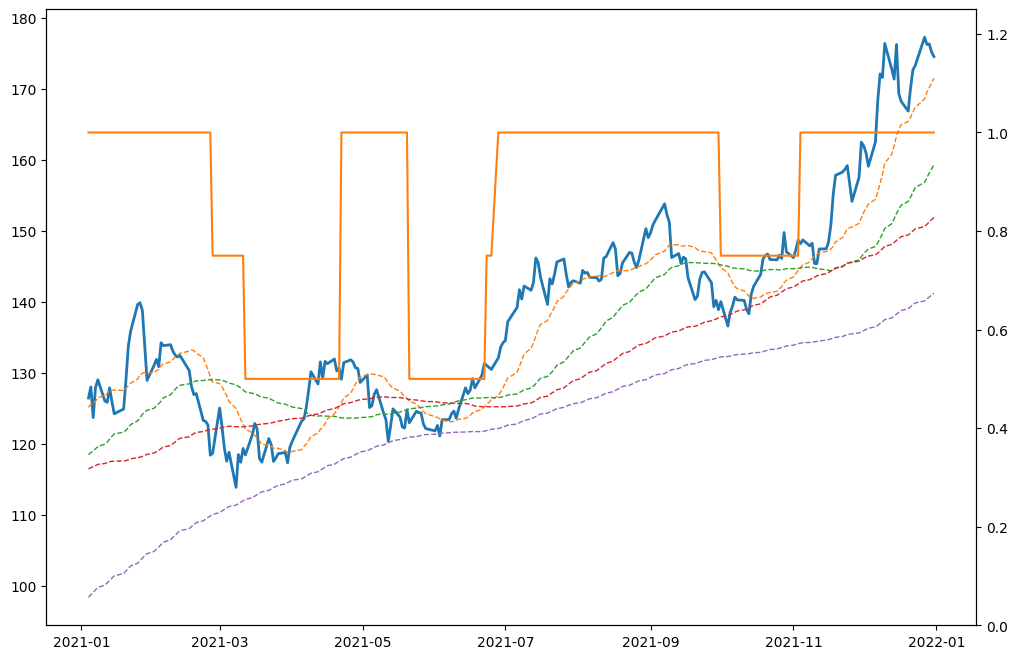

In [76]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(aapl2021["Close"], label="Close", linewidth= 2, color="C0")
ax1.plot(aapl2021["SMA20"], label="SMA20", linewidth= 1, color="C1", linestyle="--")
ax1.plot(aapl2021["SMA50"], label="SMA50", linewidth= 1, color="C2", linestyle="--") 
ax1.plot(aapl2021["SMA100"], label="SMA100", linewidth= 1, color="C3", linestyle="--")
ax1.plot(aapl2021["SMA200"], label="SMA200", linewidth= 1, color="C4", linestyle="--")

ax2 = ax1.twinx()
ax2.plot(weight.loc["2021-01":"2021-12", "Weight"], label="Weight", color="C1")
ax2.set_ylim(0, 1.25)

plt.show() 

100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


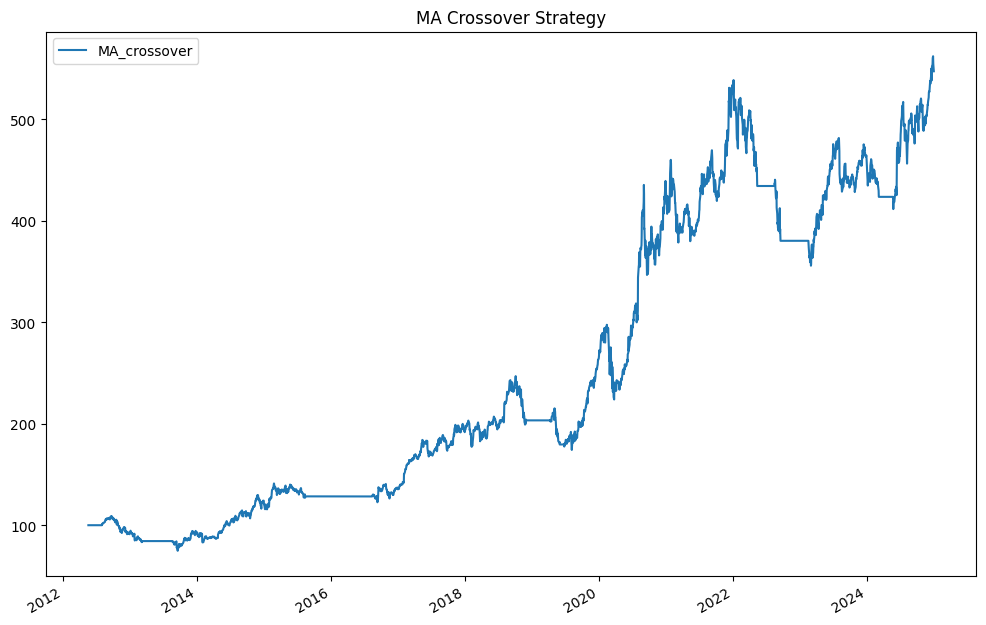

In [39]:
weight1 = weight["Weight"].to_frame(name="Close")

strategy = bt.Strategy("MA_crossover",
                       [bt.algos.WeighTarget(weight1),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, aapl_df["Close"].to_frame())
result = bt.run(backtest)

result.plot(title="MA Crossover Strategy", figsize=(12, 8))

plt.show()

### Performance of the strategy

In [46]:
aapl_df.iloc[0]["Close"]
aapl_df["return"] = aapl_df["Close"] / aapl_df.iloc[0]["Close"] * 100

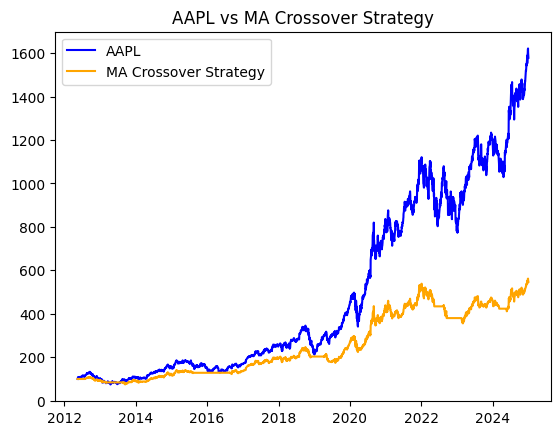

In [47]:
plt.plot(aapl_df["return"], label="AAPL", color="blue")
plt.plot(result.prices, label="MA Crossover Strategy", color="orange")
plt.title("AAPL vs MA Crossover Strategy")
plt.legend()
plt.show()

The strategy returns 500% while buy and hold Apples returns 1600% over the course of 12 years. 
* There was a dip in 2019, the strategy cleared its position and avoided large draw down. However, it was not able to buy at the v-shaped bottom. By the time the strategy enter the long position, the stock price has already recovered a fair deal. 
* In the period of 2021-2023, with a large consolidation box, the strategy suffer large drawdown. 


In [72]:

pp1 = aapl_df.loc[["2020-01-06", "2022-01-04"], ["Close"]].to_numpy()
aapl_return = pp1[1] / pp1[0] - 1
aapl_return

array([1.43321288])

In [71]:
pp2 = result.prices.loc[["2020-01-06", "2022-01-04"], ["MA_crossover"]].to_numpy()
stg_return = pp2[1] / pp2[0] - 1
stg_return

array([0.95546119])

Apple's big rally from 2020 January to 2022 January yields 143% return. While the strategy only generated return of 95%. 

In [73]:
pp3 = aapl_df.loc[["2022-01-06", "2023-01-06"], ["Close"]].to_numpy()
aapl_return = pp3[1] / pp3[0] - 1
aapl_return


array([-0.24202184])

In [74]:
pp4 = result.prices.loc[["2022-01-06", "2023-01-06"], ["MA_crossover"]].to_numpy()
stg_return = pp4[1] / pp4[0] - 1
stg_return

array([-0.25293356])

During the 2022 consolidation, Apple declined 24%, whilethe strategy suffered a decline of 25% 

### A deeper look during the consolidation phase

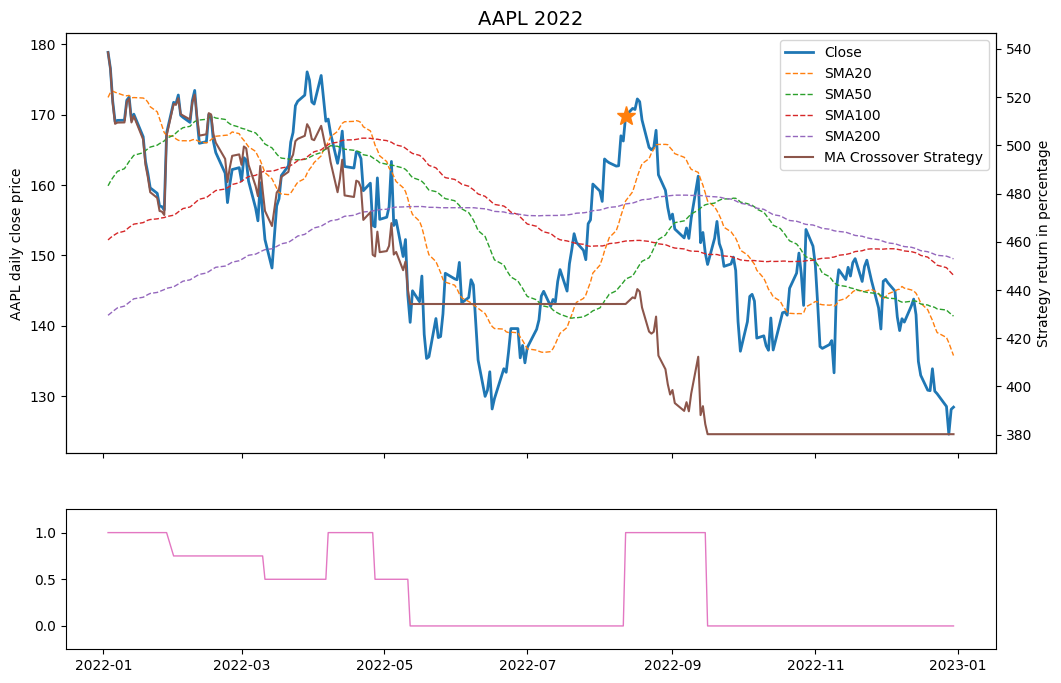

In [111]:
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(12, 8), sharex=True)

line1 = ax1.plot(aapl2022["Close"], label="Close", linewidth= 2, color="C0")
line2 = ax1.plot(aapl2022["SMA20"], label="SMA20", linewidth= 1, color="C1", linestyle="--")
line3 = ax1.plot(aapl2022["SMA50"], label="SMA50", linewidth= 1, color="C2", linestyle="--") 
line4 = ax1.plot(aapl2022["SMA100"], label="SMA100", linewidth= 1, color="C3", linestyle="--")
line5 = ax1.plot(aapl2022["SMA200"], label="SMA200", linewidth= 1, color="C4", linestyle="--")

ax1.set_title("AAPL 2022", fontsize=14)
ax1.set_ylabel("AAPL daily close price")

ax1b = ax1.twinx()
line6 = ax1b.plot(result.prices.loc["2022-01":"2022-12", "MA_crossover"], label="MA Crossover Strategy", color="C5")
ax1b.set_ylabel("Strategy return in percentage")

lines = line1 + line2 + line3 + line4 + line5 + line6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=10)

ax2.plot(weight.loc["2022-01":"2022-12", "Weight"], label="Weight", color="C6", linewidth=1)
ax2.set_ylim(-0.25, 1.25)

dt = pd.to_datetime("2022-08-12")
ax1.plot(dt, aapl2022.loc["2022-08-12", "Close"], marker="*", markersize="14", color="C1")

plt.show()

At 2022-08-12, the "star" marker in the graph, the strategy went long again. The signal came from where 20MA crosses above 200MA, however, the chart is still under consolidation and and 50MA and 100MA are under 200MA. So it was a terrible condition to go long. 

Possible solution is use the 50MA and 200MA as rules for entering long position

## Strategy v1.1 - 50MA > 200MA as trend indicator

The prerequsite to enter a long position, is that 50MA needs to be above 200MA.

Trading rules: 
1. when 20MA > 50MA  and 50MA > 200MA, buy and hold 100% 
2. when 20MA < 50MA  and 50MA > 200MA, buy and hold 75%
3. when 20MA < 100MA and 50MA > 200MA, buy and hold 50%
4. when 20MA < 200MA and 50MA > 200MA, buy and hold 0% 
   


In [ ]:
signal2 = [""] * aapl_df.shape[0]
signal2 = pd.DataFrame(signal2, index=aapl_df.index, columns=["Signal2"])

long_signal = aapl_df["SMA50"] > aapl_df["SMA200"]

signal2.loc[(aapl_df["SMA20"] > aapl_df["SMA50"]) & long_signal, "Signal2"] = "buy1"
signal2.loc[(aapl_df["SMA20"] < aapl_df["SMA50"]) & long_signal, "Signal2"] = "buy2"
signal2.loc[(aapl_df["SMA20"] < aapl_df["SMA100"]) & long_signal, "Signal2"] = "buy3"
signal2.loc[(aapl_df["SMA20"] < aapl_df["SMA200"]) & long_signal, "Signal2"] = "buy4"

signal2

,Signal2
Date,
2012-05-18,
2012-05-21,
2012-05-22,
2012-05-23,
2012-05-24,
...,...
2024-12-23,buy1
2024-12-24,buy1
2024-12-26,buy1


In [ ]:
weight2 = signal2["Signal2"].map({
    "buy1": 1.0,
    "buy2": 0.75,
    "buy3": 0.5,
    "buy4": 0.0,
}).copy()
weight2 = weight2.to_frame(name="Weight")
weight2.fillna(0, inplace=True)
weight2

,Weight
Date,
2012-05-18,0.0
2012-05-21,0.0
2012-05-22,0.0
2012-05-23,0.0
2012-05-24,0.0
...,...
2024-12-23,1.0
2024-12-24,1.0
2024-12-26,1.0


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


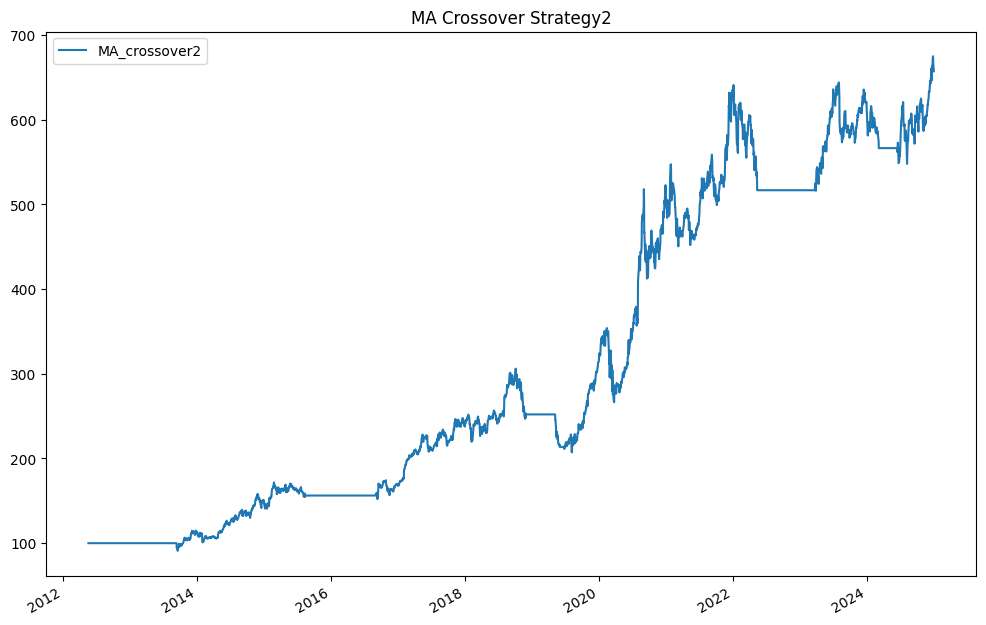

In [117]:
weight2 = weight2["Weight"].to_frame(name="Close")

strategy2 = bt.Strategy("MA_crossover2",
                       [bt.algos.WeighTarget(weight2),
                        bt.algos.Rebalance()])
backtest2 = bt.Backtest(strategy2, aapl_df["Close"].to_frame())
result2 = bt.run(backtest2)

result2.plot(title="MA Crossover Strategy2", figsize=(12, 8))

plt.show()

### Performance Analysis

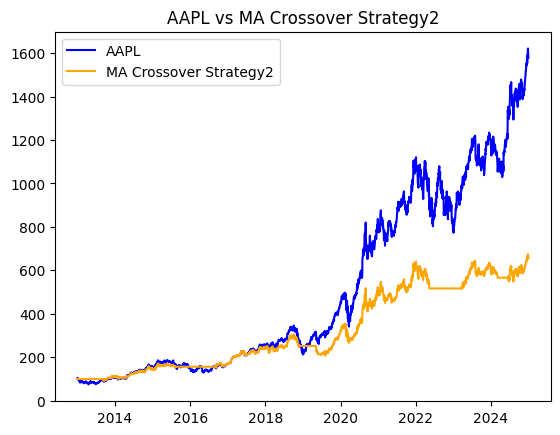

In [121]:
plt.plot(aapl_df.loc["2013":"2025", "return"], label="AAPL", color="blue")
plt.plot(result2.prices.loc["2013":"2025", "MA_crossover2"], label="MA Crossover Strategy2", color="orange")
plt.title("AAPL vs MA Crossover Strategy2")
plt.legend()
plt.show()

### A deeper look at the 2022 consolidation period


(-0.25, 1.25)

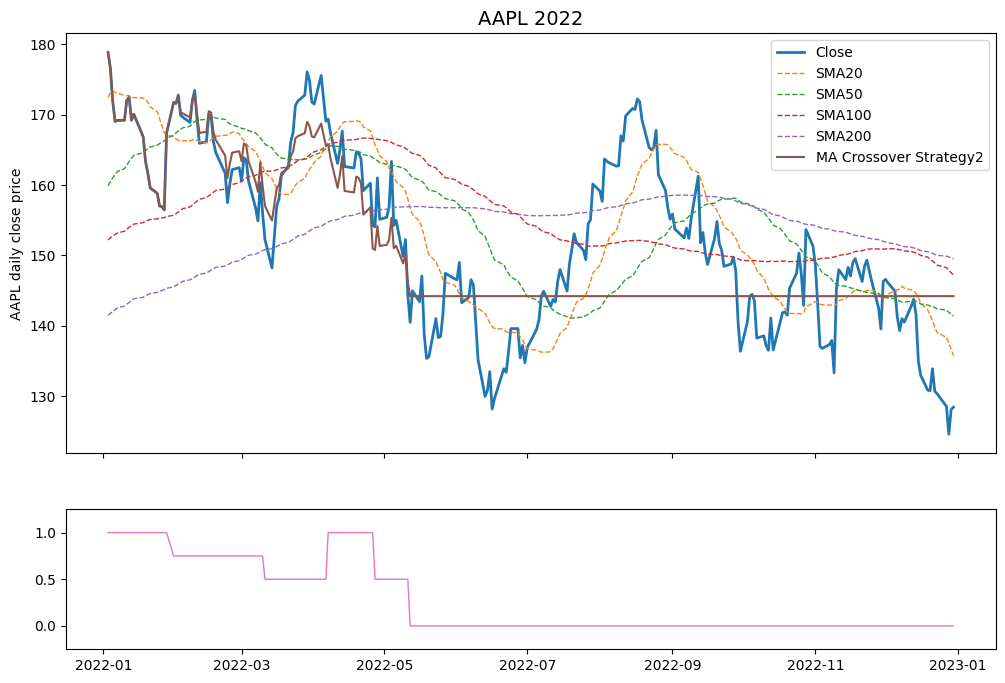

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(12, 8), sharex=True)

line1 = ax1.plot(aapl2022["Close"], label="Close", linewidth= 2, color="C0")
line2 = ax1.plot(aapl2022["SMA20"], label="SMA20", linewidth= 1, color="C1", linestyle="--")
line3 = ax1.plot(aapl2022["SMA50"], label="SMA50", linewidth= 1, color="C2", linestyle="--") 
line4 = ax1.plot(aapl2022["SMA100"], label="SMA100", linewidth= 1, color="C3", linestyle="--")
line5 = ax1.plot(aapl2022["SMA200"], label="SMA200", linewidth= 1, color="C4", linestyle="--")

ax1.set_title("AAPL 2022", fontsize=14)
ax1.set_ylabel("AAPL daily close price")

# ax1b = ax1.twinx()

r2 = result2.prices.loc["2022-01":"2022-12", "MA_crossover2"]
r0 = r2.iloc[0]
aapl0 = aapl2022["Close"].iloc[0]
factor = aapl0 / r0
r3_prices = r2 * factor

# line6 = ax1b.plot(result2.prices.loc["2022-01":"2022-12", "MA_crossover2"], label="MA Crossover Strategy2", color="C5")
line6 = ax1.plot(r3_prices, label="MA Crossover Strategy2", color="C5")
ax1b.set_ylabel("Strategy return in percentage")


lines = line1 + line2 + line3 + line4 + line5 + line6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=10)

ax2.plot(weight2.loc["2022-01":"2022-12", "Close"], label="Weight", color="C6", linewidth=1)
ax2.set_ylim(-0.25, 1.25)


Exiting the position when MA50 < MA200 cut the losses at 2022 May, helping the strategy to avoid losing money during the consolidation phase. 

## Strategy v1.2 - Both Long and Short

Expand the trading rules from strategy v1.1 and go both long and short

Trading rules: 

Long

1. when 20MA > 50MA  and 50MA > 200MA, buy and hold 100% 
2. when 20MA < 50MA  and 50MA > 200MA, buy and hold 75%
3. when 20MA < 100MA and 50MA > 200MA, buy and hold 50%
4. when 20MA < 200MA and 50MA > 200MA, hold 0% 
   
Short

5. when 20MA < 50MA  and 50MA < 200MA, sell and hold -100% 
6. when 20MA > 50MA  and 50MA < 200MA, sell and hold -75%
7. when 20MA > 100MA and 50MA < 200MA, sell and hold -50%
8. when 20MA > 200MA and 50MA < 200MA, hold 0% 


In [140]:
signal3 = [""] * aapl_df.shape[0]
signal3 = pd.DataFrame(signal3, index=aapl_df.index, columns=["Signal3"])

long_signal = aapl_df["SMA50"] > aapl_df["SMA200"]
sell_signal = aapl_df["SMA50"] < aapl_df["SMA200"]

signal3.loc[(aapl_df["SMA20"] > aapl_df["SMA50"]) & long_signal, "Signal3"] = "buy1"
signal3.loc[(aapl_df["SMA20"] < aapl_df["SMA50"]) & long_signal, "Signal3"] = "buy2"
signal3.loc[(aapl_df["SMA20"] < aapl_df["SMA100"]) & long_signal, "Signal3"] = "buy3"
signal3.loc[(aapl_df["SMA20"] < aapl_df["SMA200"]) & long_signal, "Signal3"] = "buy4"

signal3.loc[(aapl_df["SMA20"] < aapl_df["SMA50"]) & sell_signal, "Signal3"] = "sell1"
signal3.loc[(aapl_df["SMA20"] > aapl_df["SMA50"]) & sell_signal, "Signal3"] = "sell2"
signal3.loc[(aapl_df["SMA20"] > aapl_df["SMA100"]) & sell_signal, "Signal3"] = "sell3"
signal3.loc[(aapl_df["SMA20"] > aapl_df["SMA200"]) & sell_signal, "Signal3"] = "sell4"

signal3

,Signal3
Date,
2012-05-18,
2012-05-21,
2012-05-22,
2012-05-23,
2012-05-24,
...,...
2024-12-23,buy1
2024-12-24,buy1
2024-12-26,buy1


In [145]:
weight3 = signal3["Signal3"].map({
    "buy1": 1.0,
    "buy2": 0.75,
    "buy3": 0.5,
    "buy4": 0.0,
    "sell1": -1.0,
    "sell2": -0.75,
    "sell3": -0.5,
    "sell4": 0.0,
}).copy()
weight3 = weight3.to_frame(name="Weight")
weight3.fillna(0, inplace=True)
weight3

,Weight
Date,
2012-05-18,0.0
2012-05-21,0.0
2012-05-22,0.0
2012-05-23,0.0
2012-05-24,0.0
...,...
2024-12-23,1.0
2024-12-24,1.0
2024-12-26,1.0


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


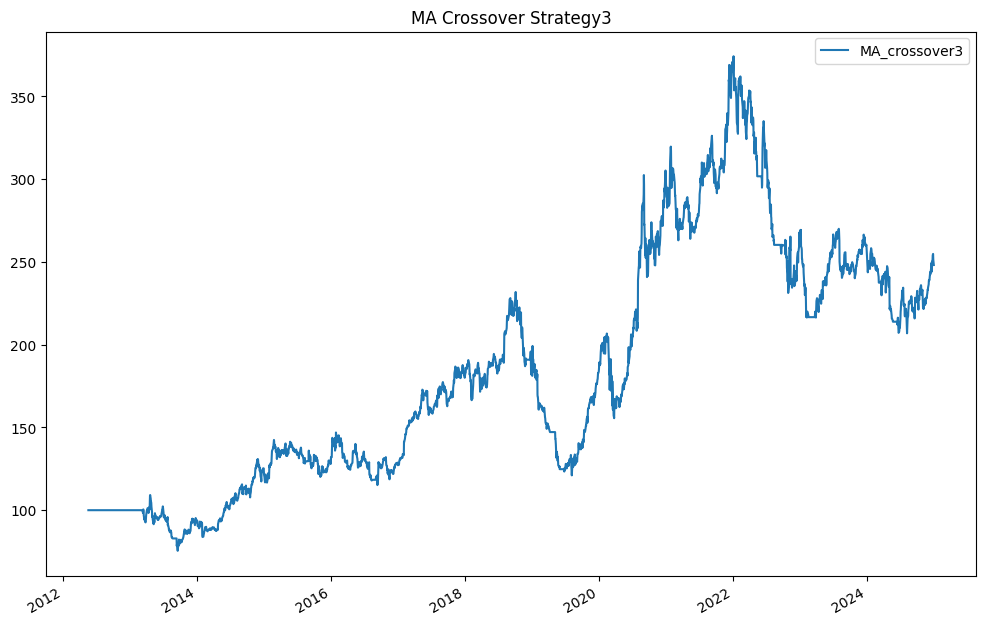

In [146]:
weight3 = weight3["Weight"].to_frame(name="Close")

strategy3 = bt.Strategy("MA_crossover3",
                       [bt.algos.WeighTarget(weight3),
                        bt.algos.Rebalance()])
backtest3 = bt.Backtest(strategy3, aapl_df["Close"].to_frame())
result3 = bt.run(backtest3)

result3.plot(title="MA Crossover Strategy3", figsize=(12, 8))

plt.show()

### Performance Analysis

(-1.25, 1.25)

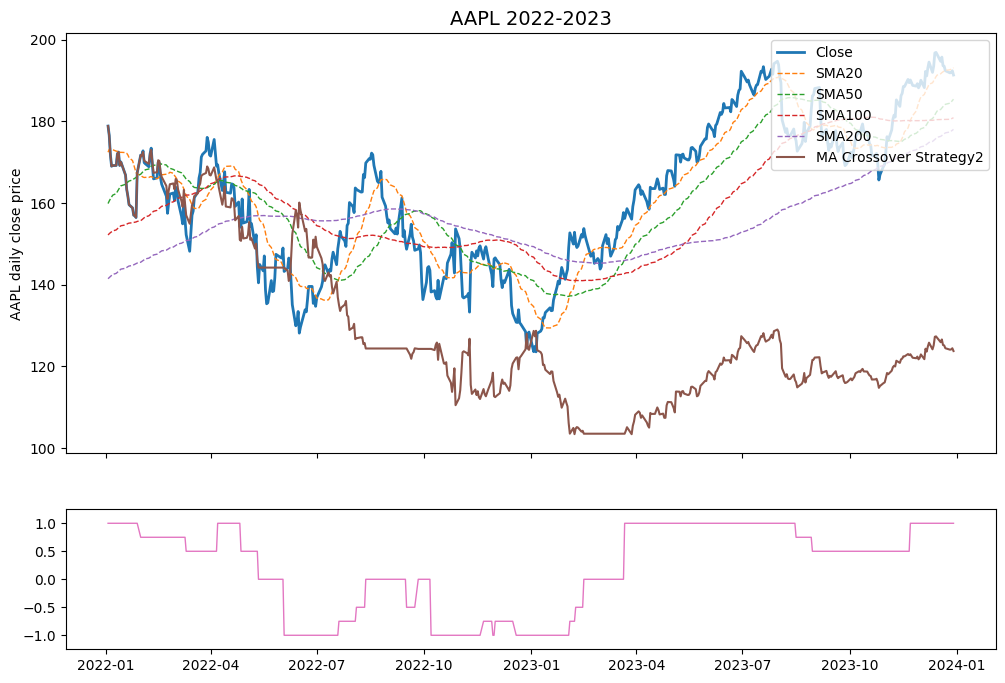

In [148]:
aapl2023 = aapl_df.loc["2022-01":"2023-12"]

fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(12, 8), sharex=True)

line1 = ax1.plot(aapl2023["Close"], label="Close", linewidth= 2, color="C0")
line2 = ax1.plot(aapl2023["SMA20"], label="SMA20", linewidth= 1, color="C1", linestyle="--")
line3 = ax1.plot(aapl2023["SMA50"], label="SMA50", linewidth= 1, color="C2", linestyle="--") 
line4 = ax1.plot(aapl2023["SMA100"], label="SMA100", linewidth= 1, color="C3", linestyle="--")
line5 = ax1.plot(aapl2023["SMA200"], label="SMA200", linewidth= 1, color="C4", linestyle="--")

ax1.set_title("AAPL 2022-2023", fontsize=14)
ax1.set_ylabel("AAPL daily close price")

# ax1b = ax1.twinx()

r3 = result3.prices.loc["2022-01":"2023-12", "MA_crossover3"]
r0 = r3.iloc[0]
aapl0 = aapl2023["Close"].iloc[0]
factor = aapl0 / r0
r3_prices = r3 * factor

# line6 = ax1b.plot(result2.prices.loc["2022-01":"2022-12", "MA_crossover2"], label="MA Crossover Strategy2", color="C5")
line6 = ax1.plot(r3_prices, label="MA Crossover Strategy2", color="C5")
ax1b.set_ylabel("Strategy return in percentage")


lines = line1 + line2 + line3 + line4 + line5 + line6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=10)

ax2.plot(weight3.loc["2022-01":"2023-12", "Close"], label="Weight", color="C6", linewidth=1)
ax2.set_ylim(-1.25, 1.25)


### Findings

Using 50MA > 200MA as an indicator to liquidate our long position to 0% helps perserve capital during a market consoliation phase. However, for a bullish stock as AAPL, 50MA < 200MA is not a good signal to go short. We need to possibly looking for **weekly moving averages** to tell the bullish trend form the bearish ones. 

## Testing strategy v1.1 and 1.2 on INTEL

In [15]:
signal4 = [""] * intc_df.shape[0]
signal4 = pd.DataFrame(signal4, index=aapl_df.index, columns=["Signal4"])

long_signal = intc_df["SMA50"] > intc_df["SMA200"]

signal4.loc[(intc_df["SMA20"] > intc_df["SMA50"]) & long_signal, "Signal4"] = "buy1"
signal4.loc[(intc_df["SMA20"] < intc_df["SMA50"]) & long_signal, "Signal4"] = "buy2"
signal4.loc[(intc_df["SMA20"] < intc_df["SMA100"]) & long_signal, "Signal4"] = "buy3"
signal4.loc[(intc_df["SMA20"] < intc_df["SMA200"]) & long_signal, "Signal4"] = "buy4"

signal4

,Signal4
Date,
2012-05-18,
2012-05-21,
2012-05-22,
2012-05-23,
2012-05-24,
...,...
2024-12-23,
2024-12-24,
2024-12-26,


In [19]:
weight4 = signal4["Signal4"].map({
    "buy1": 1.0,
    "buy2": 0.75,
    "buy3": 0.5,
    "buy4": 0.0,
}).copy()
weight4 = weight4.to_frame(name="Weight")
weight4.fillna(0, inplace=True)
weight4

,Weight
Date,
2012-05-18,0.0
2012-05-21,0.0
2012-05-22,0.0
2012-05-23,0.0
2012-05-24,0.0
...,...
2024-12-23,0.0
2024-12-24,0.0
2024-12-26,0.0


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


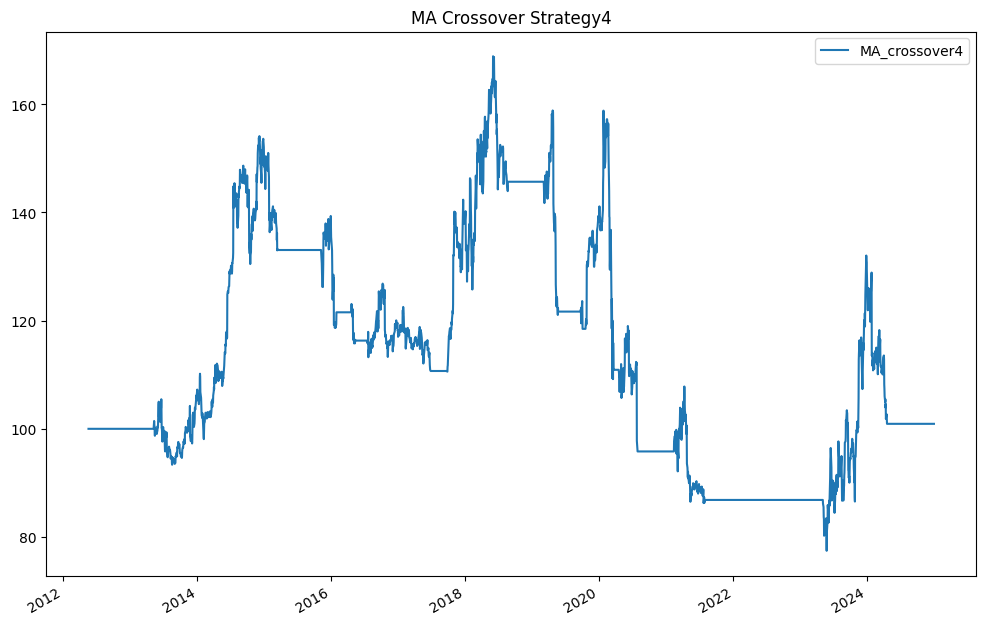

In [20]:
weight4 = weight4["Weight"].to_frame(name="Close")

strategy4 = bt.Strategy("MA_crossover4",
                       [bt.algos.WeighTarget(weight4),
                        bt.algos.Rebalance()])
backtest4 = bt.Backtest(strategy4, intc_df["Close"].to_frame())
result4 = bt.run(backtest4)

result4.plot(title="MA Crossover Strategy4", figsize=(12, 8))

plt.show()